# Introduction

To Do in this section:
- **Project Motivation**: Briefly explain why ensemble methods are popular for regression, and the practical importance of comparing Bagging (RandomForest), Boosting (XGB), and Stacking.
- **Scope**: State that the notebook compares the three methods across six datasets of varying type (synthetic/real) and dimensionality.
- **Objective**: Clarify the goal: identify which method performs best in which context, and under what circumstances.



# Model and Data Import

In [1]:
import sys
import os

sys.path.append(os.path.abspath("src"))


In [2]:
from bagging_boosting_stacking_study.constants import SEED
from bagging_boosting_stacking_study.data.loaders import load_dataset
from bagging_boosting_stacking_study.models import load_model

## Dataset Partitions

To Do in this section:
- Import all the data
- Split the data into train/test, where test is 0.1 size of total using `SEED` global variable (THATS IMPORTANT!)
- Briefly list datasets (names, n_samples, n_features, target) in a markdown table for orientation.

In [ ]:
df_friedman3 = load_dataset(dataset_name="friedman3", raw=False)
df_friedman3

,feature_0,feature_1,feature_1**2,feature_1*feature_2,feature_2,feature_2**2,feature_2_bin,feature_2_high,feature_2_low,feature_2_med,feature_3,target
0,54.329109,1316.498157,1.733167e+06,22.224393,0.016881,0.000285,low,False,True,False,4.303388,0.773470
1,36.872182,204.573936,4.185050e+04,21.384152,0.104530,0.010927,low,False,True,False,1.974375,0.415787
2,24.540331,1552.620530,2.410631e+06,80.133291,0.051612,0.002664,low,False,True,False,1.604813,1.077575
3,23.874011,458.432450,2.101603e+05,80.011875,0.174534,0.030462,low,False,True,False,5.153501,1.020377
4,94.173812,888.429667,7.893073e+05,852.873117,0.959978,0.921558,high,True,False,False,10.998138,1.062436
...,...,...,...,...,...,...,...,...,...,...,...,...
195,38.529581,867.580978,7.526968e+05,255.799238,0.294842,0.086932,low,False,True,False,5.945431,1.868813
196,65.017590,372.209819,1.385401e+05,370.169669,0.994519,0.989068,high,True,False,False,8.003550,1.259746
197,0.770473,1096.682463,1.202712e+06,369.897816,0.337288,0.113763,med,False,False,True,5.222852,1.570426
198,78.193100,714.201413,5.100837e+05,198.125854,0.277409,0.076956,low,False,True,False,10.986950,0.796250


## Model Import

- All models are pre-trained with best hyperparameters found using Optuna / RidgeCV.
- Instruction: Load 18 models: 6 RandomForestRegressor, 6 XGBRegressor, 6 StackingRegressor (each per dataset). Use `load_model` function for this. In order for this function to work, you have to run train-best-models in console before that. If you don't know how to do that, contact Szymon Pawłowski.

In [ ]:
regression_rf=load_model(dataset_name="regress", model_name="stack")

StackingRegressor(cv='prefit',
                  estimators=[('rf',
                               RandomForestRegressor(bootstrap=False,
                                                     ccp_alpha=9.537775465873154e-06,
                                                     criterion='absolute_error',
                                                     max_features=7,
                                                     min_samples_leaf=2,
                                                     min_samples_split=6,
                                                     n_estimators=450,
                                                     n_jobs=-1,
                                                     random_state=333)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=N...
                                            min_child_weight=2.7472005252618814,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1200, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('ols',
                               Pipeline(steps=[('sc', StandardScaler()),
                                               ('ols',
                                                LinearRegression(n_jobs=-1))]))],
                  final_estimator=Pipeline(steps=[('sc', StandardScaler()),
                                                  ('ridge',
                                                   Ridge(alpha=0.0,
                                                         max_iter=10000,
                                                         random_state=333,
                                                         solver='sag'))]),
                  n_jobs=-1)

## Reproducibility Note

**Instruction**: Add a short markdown block referencing the notebooks/scripts used for EDA, preprocessing, and model training/hyperparameter search. Leave the note here that states that `SEED` global variable should be used everywhere, where random_state / seed is needed.

# Evaluation Protocol

TA SEKCJA TO SAME OPISY! MARKDOWN (I EW IMPORTY METRYK)

## Metrics

**Instruction**: List and briefly define all metrics used:
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² Score (coefficient of determination)

**Tip**: A markdown bullet list with 1–2 lines explaining what each metric captures.

**Code**: Import all the needed functions to calculate these metrics

## Evaluation Scheme

In this notebook, model comparison is performed using a two-step evaluation protocol to ensure fair and rigorous assessment of model generalization.

### 1. K-Fold Cross-Validation (CV) on Training Data

- For each dataset, the training data (excluding the final test split) is used to evaluate model performance via K-Fold Cross-Validation.
- The **same splits and random seed** are used for all models to ensure direct comparability.
- During K-Fold CV, models are either retrained or their cross-validation scores (collected during hyperparameter tuning) are used to estimate performance.
- **Metrics computed:** For each fold and each model, RMSE, MAE, and R² are calculated. The mean and standard deviation across folds are reported.
- **Purpose:** This step estimates how well each model is expected to generalize to new data drawn from the same distribution as the training set and provides a basis for statistical comparison between models.

### 2. Out-of-Sample Test Set Evaluation

- After model selection and tuning (performed on the training/validation data), the **final, true comparison** is performed on the test set (10% holdout) that was **never seen during parameter tuning or training**.
- For each model, predictions are made on the test set using the pre-trained model.
- **Metrics computed:** RMSE, MAE, and R² are calculated for each model on the test set.
- **Purpose:** This evaluation provides an unbiased estimate of each model’s real-world performance and allows a direct comparison of their ability to generalize beyond the data used in hyperparameter tuning.

### Summary

- **K-Fold CV** scores enable robust statistical analysis and model ranking based on repeated sampling within the training data.
- **Test set evaluation** delivers a final, “realistic” performance measure, free from bias introduced by model selection and hyperparameter tuning.
- Both sets of results are reported for each model and dataset, and interpreted together for a comprehensive assessment.


# Main Results

## Summary Table of Metrics

**Goal:**  
To provide a clear, comprehensive overview of model performance across all datasets, using both KFold cross-validation and out-of-sample (test set) metrics, enabling quick visual comparison and identification of the best-performing models.

**To Do:**

1. **For Each Dataset:**
    - Prepare a table where each row is a model (Bagging, Boosting, Stacking).
    - For each model, include the following columns:
        - **KFold Metrics:**  
            - Mean and standard deviation (± std) of RMSE, MAE, and R² across folds.
        - **Test Set Metrics:**  
            - RMSE, MAE, and R², computed on the out-of-sample test set.
        - (Optional) Add a column for “Overfitting Gap”: difference between KFold mean and test set score for each metric.

2. **Table Structure Example:**

| Model    | RMSE (KFold) | MAE (KFold) | R² (KFold) | RMSE (Test) | MAE (Test) | R² (Test) | Overfitting Gap (RMSE) |
|----------|-------------|-------------|------------|-------------|------------|-----------|-----------------------|
| Bagging  | 1.23 ± 0.05 | 0.95 ± 0.03 | 0.89 ± 0.02| 1.29        | 1.01       | 0.88      | +0.06                 |
| Boosting | 1.19 ± 0.06 | 0.92 ± 0.04 | 0.91 ± 0.02| 1.21        | 0.96       | 0.90      | +0.02                 |
| Stacking | 1.15 ± 0.04 | 0.90 ± 0.03 | 0.92 ± 0.01| 1.14        | 0.89       | 0.92      | -0.01                 |

    - Repeat for each dataset.

3. **Highlight Best/Worst:**
    - Bold or color the best (lowest RMSE/MAE, highest R²) value in each column for easy identification.
    - Optionally, shade or annotate the worst value.

4. **Add Short Interpretation:**
    - After each table, include 1–2 sentences summarizing:
        - Which model performed best overall and by which metric.
        - Any notable observations (e.g., “Stacking had the highest R² and lowest RMSE on test for most datasets. Overfitting gap was smallest for boosting.”)

5. **(Optional) Aggregate Table:**
    - Create a master summary table showing for all datasets:
        - Which model had the best test RMSE, MAE, and R².
    - This can help reveal consistent winners across datasets.

---

**Summary:**  
This section provides a one-glance comparison of all models’ performance, supporting fast and informed discussion in subsequent analysis and synthesis sections.

## Statistical Comparison

**Goal:**  
To determine whether observed performance differences between models (e.g., bagging, boosting, stacking) are statistically significant, rather than due to random variation across folds.

**To Do:**

1. **Select Metrics and Model Pairs**
    - For each dataset and for each evaluation metric (RMSE, MAE, R²), compare the performance of all model pairs:
        - Bagging vs. Boosting
        - Bagging vs. Stacking
        - Boosting vs. Stacking

2. **Use Cross-Validation Scores**
    - Use the vector of K-Fold scores (one value per fold) for each model, per metric, per dataset.
    - These per-fold scores are necessary for paired statistical testing.

3. **Choose a Statistical Test**
    - If the distribution of score differences is approximately normal (rare, check if unsure): use the **paired t-test**.
    - Otherwise (default, more robust): use the **Wilcoxon signed-rank test** (non-parametric).
    - **Note:** Test the *null hypothesis* that the mean/median difference between model scores is zero.

4. **Perform the Tests**
    - For each model pair, metric, and dataset:
        - Compute the difference of scores per fold.
        - Run the chosen statistical test.
        - Record the test statistic and p-value.

5. **Report Results**
    - Create a table summarizing, for each dataset and metric:
        - Model pairs compared
        - Mean difference of scores
        - Test statistic
        - p-value (highlight statistically significant results, e.g. p < 0.05)
        - Optionally: 95% confidence interval of the difference

6. **Interpretation**
    - For each dataset and metric, briefly state:
        - Where differences are significant (e.g., “Stacking significantly outperforms Bagging on RMSE for California Housing, p=0.01”).
        - Where differences are not significant, note this too.

**Optional/Advanced:**
- If time allows, visualize the per-fold differences using boxplots or violin plots.
- Adjust for multiple comparisons (e.g., Bonferroni correction) if desired.

---

**Summary:**  
This section will determine which observed model performance differences are likely real and which coul

# Additional Analyses

## Model Stability

Instruction: For each model/dataset, report the standard deviation (or IQR) of KFold metrics.

Instruction: Table or bar plot to visualize.

Tip: Note which models are consistently more/less stable.

In [23]:
df_regression = load_dataset(dataset_name="regression", raw=False)
df_friedman1 = load_dataset(dataset_name="friedman1", raw=False)
df_friedman3 = load_dataset(dataset_name="friedman3", raw=False)
df_california_housing = load_dataset(dataset_name="california_housing", raw=False)
df_airfoil_self_noise = load_dataset(dataset_name="airfoil_self_noise", raw=False)
df_energy_effiency = load_dataset(dataset_name="energy_efficiency", raw=False)

In [11]:
regression_rf=load_model(dataset_name="regression", model_name="rf")
regression_xgb=load_model(dataset_name="regression", model_name="xgb")
regression_stack=load_model(dataset_name="regression", model_name="stack")

friedman1_rf=load_model(dataset_name="friedman1", model_name="rf")
friedman1_xgb=load_model(dataset_name="friedman1", model_name="xgb")
friedman1_stack=load_model(dataset_name="friedman1", model_name="stack")

friedman3_rf=load_model(dataset_name="friedman3", model_name="rf")
friedman3_xgb=load_model(dataset_name="friedman3", model_name="xgb")
friedman3_stack=load_model(dataset_name="friedman3", model_name="stack")

california_housing_rf=load_model(dataset_name="california_housing", model_name="rf")
california_housing_xgb=load_model(dataset_name="california_housing", model_name="xgb")
california_housing_stack=load_model(dataset_name="california_housing", model_name="stack")

airfoil_self_noise_rf=load_model(dataset_name="airfoil_self_noise", model_name="rf")
airfoil_self_noise_xgb=load_model(dataset_name="airfoil_self_noise", model_name="xgb")
airfoil_self_noise_stack=load_model(dataset_name="airfoil_self_noise", model_name="stack")

energy_efficiency_rf=load_model(dataset_name="energy_efficiency", model_name="rf")
energy_efficiency_xgb=load_model(dataset_name="energy_efficiency", model_name="xgb")
energy_efficiency_stack=load_model(dataset_name="energy_efficiency", model_name="stack")

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr

## Relative Performance Ranking

Instruction: Rank each model per dataset/metric (1 = best, 3 = worst).

Instruction: Provide a ranking table.

Tip: Helps to spot if a model is a frequent winner or if order varies.

## Error Analysis

### Error Distribution Plots

Instruction: For 1–2 datasets, plot error distributions (histograms or boxplots of residuals/errors) for all models on the out-of-sample set.

Tip: Note bias, outliers, “fatter tails.”

In [31]:
X_ch, y_ch = df_california_housing.drop('target',axis=1), df_california_housing['target']
X_ee, y_ee = df_energy_effiency.drop('target', axis=1), df_energy_effiency['target']

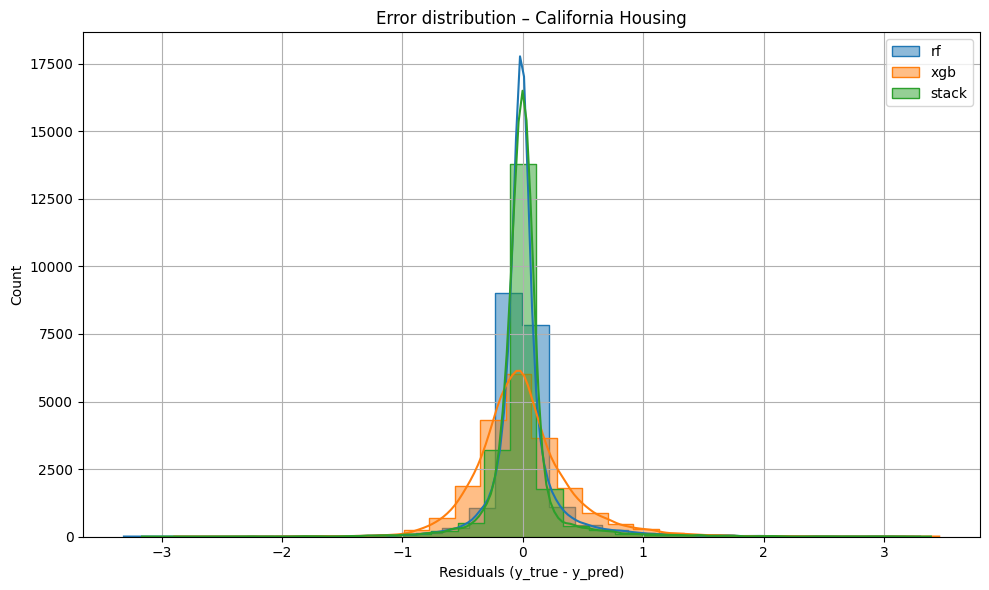

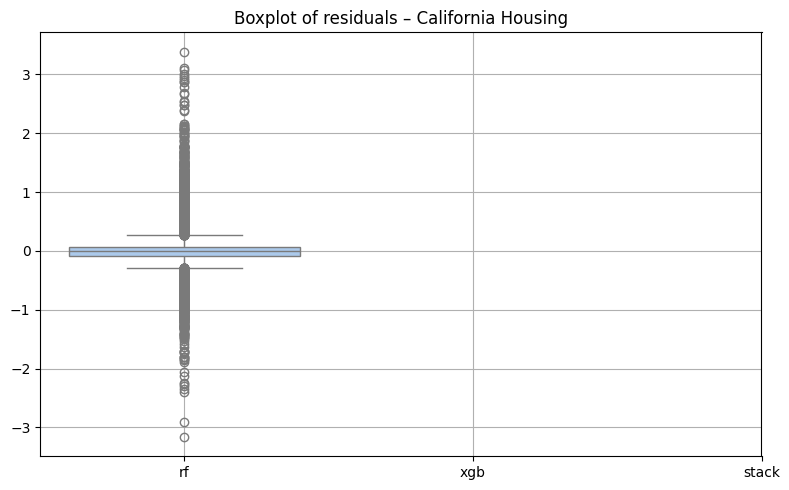

In [36]:
# 2. Oblicz reszty (y_true - y_pred)
residuals = {
    "rf": y_ch- california_housing_rf.predict(X_ch),
    "xgb": y_ch - california_housing_xgb.predict(X_ch),
    "stack": y_ch - california_housing_stack.predict(X_ch)
}

# 3. Histogramy
plt.figure(figsize=(10, 6))
for model_name, res in residuals.items():
    sns.histplot(res, label=model_name, kde=True, stat="count", bins=30, element="step")
plt.title("Error distribution – California Housing")
plt.xlabel("Residuals (y_true - y_pred)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=[residuals["rf"], residuals["xgb"], residuals["stack"]], palette="pastel")
plt.xticks([0, 1, 2], ["rf", "xgb", "stack"])
plt.title("Boxplot of residuals – California Housing")
plt.grid(True)
plt.tight_layout()
plt.show()


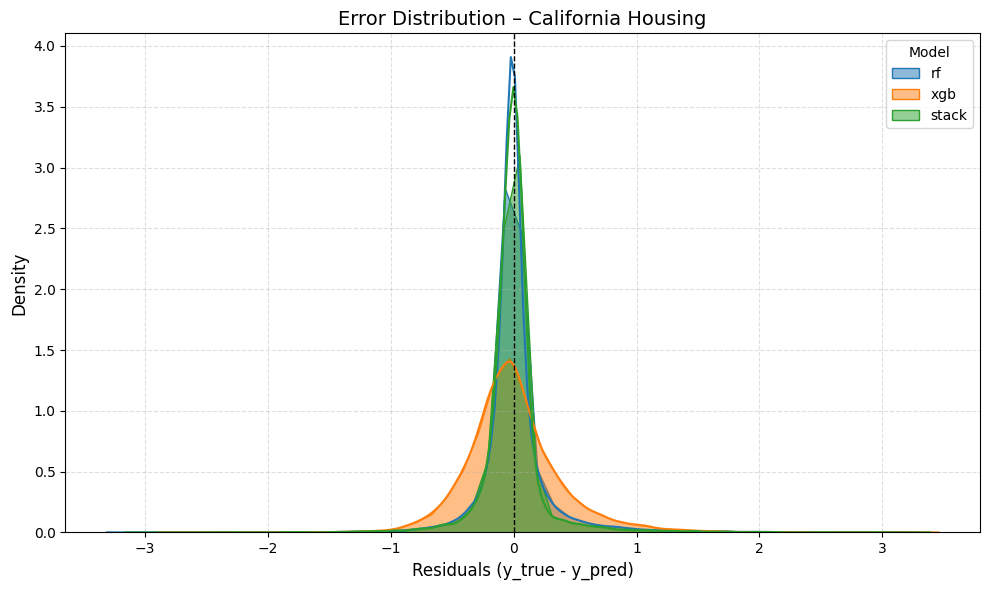

In [34]:
# 3. Histogram rozkładu błędów
plt.figure(figsize=(10, 6))

# iteracja po modelach i ich resztach
for model_name, res in residuals.items():
    sns.histplot(res, label=model_name, kde=True, stat="density", bins=50, element="poly", alpha=0.5)

plt.title("Error Distribution – California Housing", fontsize=14)
plt.xlabel("Residuals (y_true - y_pred)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.legend(title="Model")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()




### True vs. Predicted Scatter Plots

Instruction: For 1–2 datasets, plot y_true vs y_pred for each model (on out-of-sample set).

Tip: Helps visualize bias, spread, or systematic errors.

## Overfitting Check

Instruction: Compare mean KFold metric to out-of-sample metric for each model/dataset.

Instruction: Table or bar plot of the “overfitting gap.”

Tip: Comment on which models/datasets overfit more.

## Runtime Comparison (Optional)

Instruction: If timing data is available, create a table/barplot of training/prediction times for each model/dataset.

Tip: Comment on practical speed differences.

## Feature Importance (Optional)

Instruction: For RandomForest and XGB (not stacking), list top n features per dataset (by feature_importances_).

Tip: Can be a table or markdown summary.

# Summary and Conclusion

### Key Results Table
Instruction: Create a summary table with best out-of-sample metric per model/dataset (and highlight the “winner”).

Tip: Makes the main takeaways instantly clear.

###  Dataset-by-Dataset Takeaways
Instruction: For each dataset, write 1–2 bullets:

Which model won, how big was the difference, and any interesting observations (e.g., "Stacking wins on high-dim synthetic, XGB on real-world, differences are small on [dataset]").

Tip: Speculate on possible reasons (e.g., noise, nonlinearity, sample size).

###  General Insights
Instruction: Write a short narrative summarizing patterns across datasets and models:

When does each method tend to win?

Are some models more robust? Do some overfit more?

Any practical tradeoffs (e.g., computation, interpretability)?

### Conclusion

Instruction: Wrap up main lessons from the benchmark.

Instruction: Discuss limitations (e.g., only three ensemble types, only regression).

Instruction: Suggest potential future work (e.g., classification, deeper stacking ablation, more diverse datasets).